In this notebook, we will calculate the bias/variance tradeoff using polynomial regression.

Our dataset consists of a independent variable $x$ and a dependent variable $y$ (targets), related by our ground truth model $y=f(x)$. We will choose a specific model $f(x)=0.5x+x^2$, and generate $i=1,\ldots,N$ observations using the following generative model
$$
y_i=f(x_i)+\epsilon_i
$$
where the irreducible or measurement noise is sampled from a gaussian distribution
$$
\epsilon_i\sim {\cal N}(0,\sigma_\epsilon^2)
$$
We generate a training set with $N$ observations uniformly distributed along the interval $x\in[-x_{max},x_{max}]$, with $x_{max}=1$ and a test set consisting of a single point $(x_{test},y_{test})$, with $x_{test}=1.1$.

In [9]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

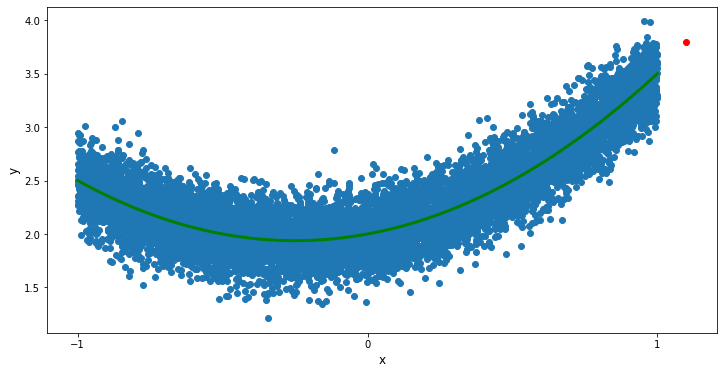

In [10]:
# define ground truth model f(x)

def f(x):
          return 0.5 * x + x**2+2


# full dataset (x,y) set consists of N observations in the interval [-x_max,x_max]
# we will subsample from this to create different training sets
N=10000
x_max=1
x=x_max*(2*np.random.rand(N)-1) # uniform

# measurement noise
sigma_epsilon=0.2 #standard deviation
epsilon=sigma_epsilon*np.random.randn(N) # gaussian mu+sigma*np.random.randn
# full dataset set (x,y)
y=f(x)+epsilon 

# test set outside of training range:
x_test=x_max+0.1
y_test=f(x_test)+sigma_epsilon*np.random.randn()

#plot
plt.figure(figsize=(12, 6))
x_range = np.linspace(-x_max, x_max, 1000)
# ground truth model
plt.plot(x_range, f(x_range), 'g', linewidth=3.0)
# training set
plt.scatter(x, y)
# test set
plt.scatter(x_test, y_test, c='r')
#
plt.xlabel('x', size=12)
plt.ylabel('y', size=12)
plt.xticks(np.arange(-x_max, x_max + 1))
plt.show()

Our goal is to learn a function $\hat{f}(x)$ that best approximates our ground truth model $f(x)$ from the noisy observations in the training set, and accurately predict the target in the test set.

We will compare several alternative models, within the class of polynomials of degree $d$:
$$
\hat f_d(x|w)=\sum_{i=0}^d w^{(d)}_i x^i
$$
where $w^{(d)}_i$ are the parameters to be learned using polynomial regression (i.e., maximizing the likelihood, or equivalently minimizing the squared error of the training set), via the function np.polyfit. We will pick $d=0,\ldots,5$. 

We will perform $a=1,\ldots,n_{exp}=6$ experiments. For each experiment, we will create a new training set $S_{train}^a=[x_i,y_i]$ by randomly subsampling $0.5\%$ of the original $N$ observations, and fitting each model $\hat f_d(x|w)$ to the training set $S_{train}^a$, to learn the parameters $w^{(d)}_i(S_{train}^a)$. For each learned model $w^{(d)}_i(S_{train}^a)$, we will then make a prediction for the test set $y_{test}=\hat f(x_{test}|w^{(d)}_i(S_{train}^a)$. Crucially, the learned parameters $w^{(d)}_i(S_{train}^a)$ and thus the prediction $y_{test}$ will be different in the different experiments: they are functions of the training set  $S_{train}^a$. We will thus plot the learned models $y=\hat f(x|w^{(d)}_i(S_{train}^a)$ for all training sets.

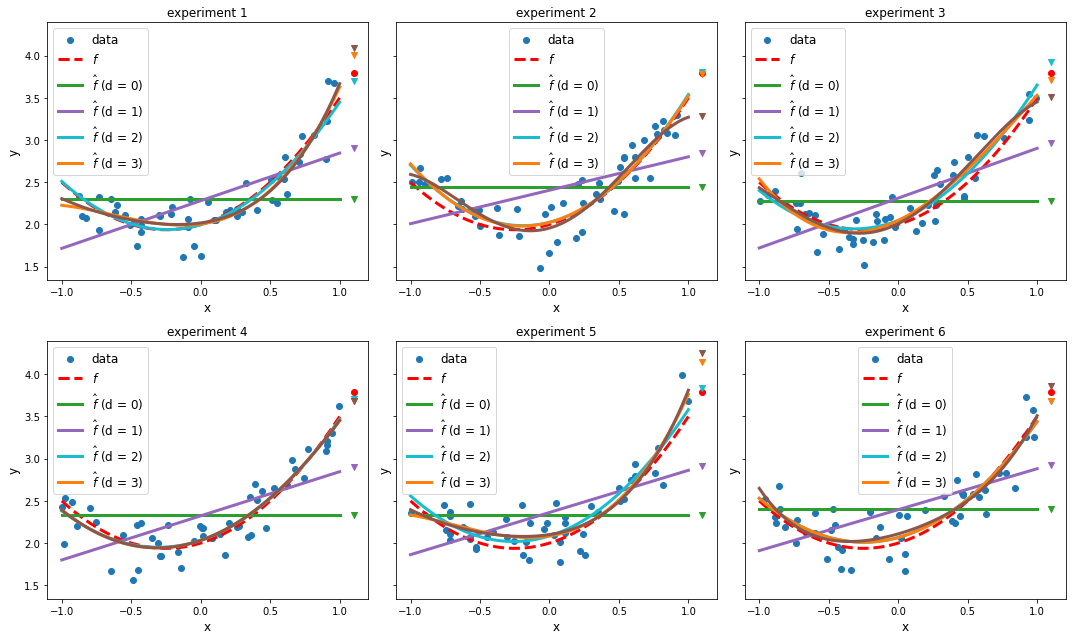

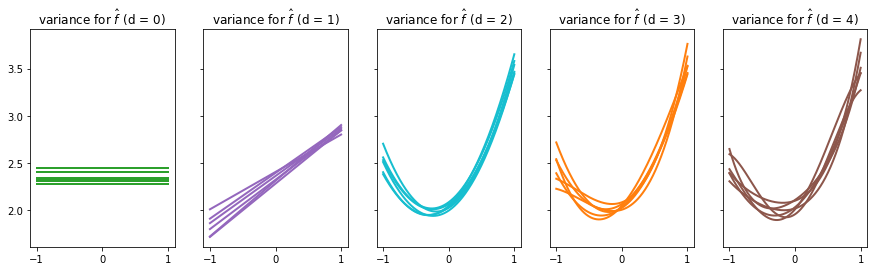

In [12]:
# alternative models: polynomials of degree d in d_arr
d_arr=[0,1,2,3,4]

#our class of models to fit: polynomials of degree d
def f_hat(x, w):
    d = len(w) - 1
    return np.sum(w * np.power(x, np.expand_dims(np.arange(d, -1, -1), 1)).T, 1)
    # note that np.arange(d,-1,-1)=[d,d-1,...,0]

# number of experiments to perform
n_exp=6
# training data in each experiment
n=int(0.005*N)
# indices for sampling disjoint training sets for each experiment from the data above
idx=[]
for i in range(n_exp):
    idx.append(np.random.permutation(N)[:n])


    
cnt = 0
colors = np.array(['tab:green', 'tab:purple', 'tab:cyan', 'tab:orange', 'tab:brown', 'tab:pink'])
fig, axs = plt.subplots(2, 3, sharey=True, figsize=(15, 9))
# store all polynomial fits for each experiment
wtot=[] 

for i in range(2):
    for j in range(3):
        # creating one training set
        x_train,y_train=x[idx[cnt]],y[idx[cnt]]
        w=[]
        # append polynomial fits    
        for d in d_arr:
            w.append(np.polyfit(x_train,y_train,d))
        wtot.append(w)
        # plot training data
        axs[i, j].scatter(x_train, y_train)
        # plot ground truth
        axs[i, j].plot(x_range, f(x_range), 'r', linewidth=3.0,linestyle='--')
        # plot model fits
        for k in range(len(w)):
            axs[i, j].plot(x_range, f_hat(x_range, w[k]), colors[k], linewidth=3.0)
        # plot test data    
        axs[i, j].scatter(x_test, y_test, c='r')
        # plot prediction of test data using polynomial fits    
        for k in range(len(w)):
            axs[i, j].scatter(x_test, f_hat(x_test, w[k]), c=colors[k],marker='v')
                
        axs[i, j].set_xlabel('x', size=12)
        axs[i, j].set_ylabel('y', size=12)
        axs[i, j].legend(['data',r'$f$', r'$\hat{f}$ (d = 0)', r'$\hat{f}$ (d = 1)', 
                          r'$\hat{f}$ (d = 2)', r'$\hat{f}$ (d = 3)'], fontsize=12)
        axs[i, j].title.set_text('experiment {}'.format(cnt+1))
        cnt += 1
plt.tight_layout()
plt.show()

# visualize model fits to different experiments: variance

fig, axs = plt.subplots(1,len(d_arr), sharey=True, figsize=(15, 4))
for i in range(len(d_arr)):
    for k in range(len(wtot)):
        axs[i].plot(x_range, f_hat(x_range, wtot[k][i]), colors[i], linewidth=2.0)
        axs[i].title.set_text('variance for ' r'$\hat f$ (d = {})'.format(d_arr[i]))


Models with low complexity, such as a horizontal line, are more consistent when learned from different training sets (low variance), while models with many parameters show more variability (high variance). 

We will estimate the **bias** of each model class as its average test set prediction (averaged over all different training sets) minus the ground truth:
$$
bias[\hat f_d(x_{test})]=\mathbb{E}_{exp}[ \hat f_d(x_{test}|w^{(d)}_i)]-f(x_{test})
$$
where 
$$
\mathbb{E}_{exp}[ \hat f_d(x|w^{(d)}_i)]={1\over n_{exp}}\sum_{a=1}^{n_{exp}}\hat f_d(x|w^{(d)}_i(S_{train}^a))
$$

We will estimate the **variance** of each model class as the mean square deviation of the test prediction from the its average test set prediction (averaged over all different training sets):
$$
var[\hat f_d(x_{test})]=\mathbb{E}_{exp}[ \left(\hat f_d(x_{test}|w^{(d)}_i)-\mathbb{E}_{exp}[\hat f_d(x_{test}|w^{(d)}_i)]\right)^2]
$$
where 
$$
\mathbb{E}_{exp}[ \hat f_d(x|w^{(d)}_i)]={1\over n_{exp}}\sum_{a=1}^{n_{exp}}\hat f_d(x|w^{(d)}_i(S_{train}^a))
$$

In [ ]:
# number of experiments (different training sets sampled from the population)

# store predictions for test data point


    # generate training sets
        # fit training set with different models   

# expected value of prediction for each model

# variance of prediction across experiments


# bias squared


nplots=len(d_arr)
fig, axs = plt.subplots(nplots, 1, sharex=True, sharey=True, figsize=(12, 3*nplots))
ylim=np.percentile(y_hat_test.flatten(),[1,99]) # find percentiles for setting plot limits
for k in range(nplots):
    # distribution of predictions across training sets
    axs[k].hist(y_hat_test[k], density=True, color=colors[k], alpha=0.6)             
    xlim = axs[k].get_xlim()
    # true value of test data 
    axs[k].plot([f(x_test), f(x_test)], [0, 1], 'r', linewidth=3.0)
    # expected value of test prediction
    axs[k].plot([y_hat_test_mean[k], y_hat_test_mean[k]], [0, 1], c='k', linewidth=3.0)
    axs[k].title.set_text('d = {}, variance = {:.3f}, bias^2 = {:.3f}'.format(d_arr[k],variance1[k],bias_squared[k]))
    axs[k].legend([r'$f(x_{test})$', r'$\mathbb{E}[\hat{f}(x_{test})]$', r'$\hat{f}(x_{test})$'], fontsize=12)
    axs[k].set_xlim(ylim)
# overlay gaussian distribution of predictions with expected mean and variance
for k in range(nplots):
    x_range = np.linspace(xlim[0], xlim[1], 1000)
    axs[k].plot(x_range, stats.norm.pdf(x_range, y_hat_test_mean[k], y_hat_test_std[k]), color=colors[k], ls='--')
    
plt.suptitle(r'Histogram of $\hat{f}(x_{test})$', size=12)
plt.show()

When we plot the bias and variance as a function of the degree of the learned polynomial, we find that:
- Models with low complexity have high bias and low variance
- Models with high complexity have low bias and high variance.

In [ ]:
# plot bias squared and variance from above
# bias squared
bias_squared = (np.mean(y_hat_test, 1) - f(x_test)) ** 2
# variance
var_y_hat_test = np.var(y_hat_test, 1)
plt.figure(figsize=(12, 8))
plt.plot(d_arr, bias_squared, 'y--')
plt.plot(d_arr, var_y_hat_test, 'b--')
plt.plot(d_arr, bias_squared+var_y_hat_test+sigma_epsilon**2, 'r--')
plt.xticks(d_arr)
plt.xlabel('d=degree of polynomial', size=12)
plt.ylabel('squared error', size=12)
plt.legend([r'bias squared: $(\mathbb{E}[\hat{f}(x)] - f(x))^2$',
            r'$var(\hat{f}(x))$'], loc='upper center', fontsize=12)
plt.show()